Charger les images: toutes les images COVID + autant d'images Pneumonie + Lung Opacity.

Visualiser un ensemble d'images aléatoire.

CNN minimal avec 1 couche de convolution et une dense.

_Résultat_: le score de bonnes prédictions  et les F1-scores oscillent autour de 0.77-0.8.


L'environnement s'appelle 'DSTest__proj_env06' sur ma machine. On trouve les versions des librairies dans la 2e cellule de code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from timeit import default_timer as timer

import time

image_path = '../data'

2024-07-10 10:02:04.817674: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 10:02:04.842313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Added for checking versions.

import matplotlib
import sklearn
import tensorflow as tf

print(np.__version__)  # 1.26.4
print(matplotlib.__version__)  # 3.8.4
print(sklearn.__version__)  # 1.5.1
print(cv2.__version__)  # 4.9.0
print(tf.__version__)   # 2.13.1

1.26.4
3.8.4
1.5.1
4.9.0
2.13.1


Fonctions pour charger les images (adapté de: 'RF_data_augmentation.ipynb').

In [3]:
# Hyperparamètres (réduction de l'image)
IMG_HEIGHT = 28
IMG_WIDTH = 28

# L'architecture du CNN peut aussi être déplacée ici.

In [4]:
def list_img(image_dir: str, sought_ext='.png'):
    """
    List of files with a specific extension in a folder.

    Useful for extracting the number of files.
    Can also be used as the first step of the next version of function 'load_images'.

    Args:
        image_dir (str): path to folder
        sought_ext (str, optional): sought extension. Defaults to '.png'.

    Returns:
        list of str: the list of image files in the order of os.listdir.
    """
    files = os.listdir(image_dir)
    lst_images = [file_name for file_name in files if file_name.endswith(sought_ext)]
    return lst_images

In [5]:
def load_images(image_dir, label, limit=None):
    """
    Fonction pour charger les images d'un dossier.
    
    Args:
        image_dir (str): path to folder
        label (str or int): the label to associate to the images
        limit (int, optional): the max number of files to load.
            Defaults to None (load all PNG images).

    Constants imported from higher level: 
        IMG_HEIGHT, IMG_WIDTH
    
    Returns:
        tensor NImages x HEIGHT x WIDTH : the images resized to HEIGHT x WIDTH;
        1d array (NImages,) : the label expanded to array.
    
    Possible improvements.
    1. Speed up the function by preallocating the tensor first,
    then writing into it.
    
    2. Select the files as a random subset
    rather than by the order of the function 'os.listdir'.

    3. Check for extension PNG inside the definition of 'files',
    so that the function always loads the appropriate number of images
    ignoring the other  file types.
    
    4. Return the  filenames of the extracted images as a 3rd output.
    """
    image_data = []
    label_data = []
    files = os.listdir(image_dir)
    if limit:
        files = files[:limit]
    for file_name in files:
        if file_name.endswith('.png'):
            img_path = os.path.join(image_dir, file_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                image_data.append(img)
                label_data.append(label)
            except Exception as e:
                print(f"Erreur de chargement de l'image {file_name} : {e}")
    
    return np.array(image_data), np.array(label_data)

In [6]:
def load_data(image_dirs, labels, limits=None):
    """
    Load data from several folders

    Args:
        image_dirs (list of 'str'): the paths to folders.
        labels (list of 'str' of the same length): _description_
        limits (list if int of None, optional): the number of files to load.
            Defaults to None.

    Returns:
        tensor sum_{folders}(NImages) x HEIGHT x WIDTH :
            the images resized to HEIGHT x WIDTH;
        1d array (sum_{folders}(NImages),) : the labels expanded to array.
    """
    all_images = []
    all_labels = []
    
    limits2 = [None] * len(image_dirs) if limits is None else limits
    
    for i, image_dir in enumerate(image_dirs):
        images, label_data = load_images(image_dir, labels[i], limits2[i])
        all_images.append(images)
        all_labels.append(label_data)
    return np.concatenate(all_images), np.concatenate(all_labels)

In [7]:
def cond2folder(condition):
    return os.path.join(image_path, condition, "images")

Charger les images: toutes les images COVID + autant d'images Pneumonie + Lung Opacity, que COVID.

In [8]:
lst_conditions = ['COVID', 'Lung_Opacity', 'Viral Pneumonia']
lst_dirs = list(map(cond2folder, lst_conditions))
print(lst_dirs)

lst_labels = [1, 0, 0]

print("labels:", lst_labels)

# determine the number of images to load
# num_COVID_img = len(list_img(lst_dirs[0]))
lst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))
print("Total number of images for each condition:", lst_nums_images)
# [3616, 6012, 1345]


['../data/COVID/images', '../data/Lung_Opacity/images', '../data/Viral Pneumonia/images']
labels: [1, 0, 0]
Total number of images for each condition: [3616, 6012, 1345]


In [9]:
# Number of images to extract.
def scale_arr_to_sum(arr_to_scale:np.ndarray, new_sum):
    """
    Scales an array to (approximately) fit the new sum.
    The new array is rounded and converted to integers.
    
    Args:
        arr_to_scale (1-dimensional np.ndarray): the original array
        new_sum (scalar): the new sum
    """
    coeff = new_sum / arr_to_scale.sum()
    return (np.round(coeff * arr_to_scale)).astype(int)


def scale_tail_to_match_head(arr):
    """
    Scales the slice of 'arr' without the 1st element
    so that its sum approximately matches the 1st element.
    The input is converted to a numpy array.

    Args:
        arr (list or ndarray of ints): the original array

    Returns:
        ndarray of ints: the rescaled array, where the 1st element is close to half of the total sum.
    """
    res = np.array(arr)
    res[1:] = scale_arr_to_sum(res[1:], arr[0])
    return res


# Check the function
print(scale_arr_to_sum(np.arange(5), 25))
# [ 0  2  5  8 10]

print(scale_tail_to_match_head(np.arange(50, 10, -10)))
# [50 22 17 11]

[ 0  2  5  8 10]
[50 22 17 11]


In [10]:
balanced_lst_nums_images = scale_tail_to_match_head(lst_nums_images)

print(balanced_lst_nums_images)
# [3616 2955  661]


[3616 2955  661]


Extract images.

In [11]:
start = time.time()
data, labels = load_data(lst_dirs, lst_labels, balanced_lst_nums_images)
done = time.time()

elapsed = done - start
print(f'Loading data : {elapsed:.2f} sec \n\n')
# 7 sec

print(type(data))  # ndarray
print(data.shape)  # (7232, 28, 28, 3)

print(type(labels))  # ndarray
print(labels.shape)  # (7232,)



Loading data : 7.00 sec 


<class 'numpy.ndarray'>
(7232, 28, 28, 3)
<class 'numpy.ndarray'>
(7232,)


Show random images.

In [12]:
def subplots_random_images(tens_img: np.ndarray, labels, n_plots: int, rng):
    """
    Plot random images from the tensor 'tens_img'.

    Args:
        tens_img (3d or 4d tensor): images.
        labels (1d array-like): the labels of images.
        n_plots (int): the number of images to plot.
        rng : the random number generator

    Returns:
        fig; ax; the indices of plotted images.
    
    Possible improvement: make the 2 last parameters optional.
    """
    indices = rng.choice(tens_img.shape[0], size=n_plots, replace=False)

    fig, axes = plt.subplots(1, n_plots)
    fig.set_figheight(5)
    fig.set_figwidth(16)
    for n_plot in range(n_plots):
        axes[n_plot].imshow(tens_img.take(indices[n_plot], axis=0),
                        cmap='gray')
        axes[n_plot].set_title(labels[indices[n_plot]])
    return fig, axes, indices

(<Figure size 1600x500 with 6 Axes>,
 array([<Axes: title={'center': '0'}>, <Axes: title={'center': '0'}>,
        <Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '1'}>, <Axes: title={'center': '1'}>],
       dtype=object),
 array([5459, 3699, 6871, 3419, 1042,  252]))

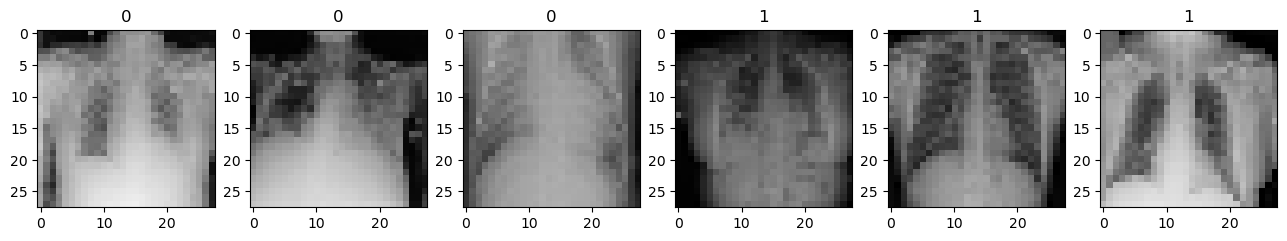

In [13]:
n_plots = 6

# Show 'n_plots' random indices.
rng = np.random.default_rng(1)

subplots_random_images(data, labels, n_plots, rng)

In [14]:
# Check the distribution of labels.
lbl_unique, lbl_counts = np.unique(labels, return_counts=True)

print(lbl_unique)  # ['COVID' 'Non_COVID']
print('--------')
print(lbl_counts)  # [3616 3616]

# As expected, the classes are balanced.


[0 1]
--------
[3616 3616]


# Train-Test split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=labels)

print(X_train.shape)  # (5062, 28, 28, 3)
print(X_test.shape)   # (2170, 28, 28, 3)

(5062, 28, 28, 3)
(2170, 28, 28, 3)


# Générateur de données
(vient du notebook 3 du module CNN)

In [16]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()


In [17]:
train_dataset = train_datagen.flow(X_train,Y_train,
                        batch_size = 128)


test_dataset = test_datagen.flow(X_test, Y_test, batch_size = 128)

#  Callbacks


In [18]:
# from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

Dans le cadre de notre modèle, on utilisera deux callbacks : Un Early Stop et un Learning rate reducer.

In [19]:
early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
    # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

time_callback = TimingCallback()

# This defined components of a CNN, but neither built a model,
# nor required resources from the machine.

# Construction d'un CNN Classique

* Couche de Convolution comportant les paramètres suivants :
    * filters = 32: La couche sera composée de 32 matrices de convolution.
    * kernel_size = (3, 3) : le noyau de convolution sera de dimension 3x3.
    * activation = 'relu'.
    * input_shape =  (100,100,3).
    * On ajoutera les paramètres padding = 'valid' et kernel_regularizer=regularizers.l2(0.00001).

* Couche de Max Pooling avec comme paramètres :
    * pool_size = 2
    * strides = 2
    * padding = 'valid'

* Couche de Dropout avec le paramètre rate = 0.5

* Couche d'applatissement

* Couche dense à 1 neurone. 

    * model.add(Dense(1, activation='sigmoid'))


In [20]:
# Instanciation du modèle 
model = Sequential()

model.add(Conv2D(filters=8,
                kernel_size=(3,3),
                activation="relu",
                padding="valid",
                input_shape=(28, 28, 3)))

model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

model.add(Dropout(0.5))

model.add(Flatten())

# model.add(Dense(1,activation="linear"))
model.add(Dense(1, activation='sigmoid'))

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 1)                 1353      
                                                                 
Total params: 1577 (6.16 KB)
Trainable params: 1577 (6.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

# Entraînement du modèle


In [22]:
#Compilation du modèle
model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics=['acc'])

In [23]:
# Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks.

batch_size = 128
epochs = 20

start = time.time()
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            callbacks = [
                        reduce_learning_rate,
                        early_stopping,
                        time_callback
                        ],
            verbose=True)
done = time.time()

elapsed = done - start
print(f'Training : {elapsed:.2f} sec \n\n')
# 30 sec


Epoch 1/20
39/39 [==============================] - 2s 40ms/step - loss: 0.7088 - acc: 0.5251 - val_loss: 0.6705 - val_acc: 0.6041 - lr: 0.0010
Epoch 2/20
39/39 [==============================] - 1s 37ms/step - loss: 0.6656 - acc: 0.6066 - val_loss: 0.6366 - val_acc: 0.7000 - lr: 0.0010
Epoch 3/20
39/39 [==============================] - 1s 35ms/step - loss: 0.6350 - acc: 0.6573 - val_loss: 0.6016 - val_acc: 0.7111 - lr: 0.0010
Epoch 4/20
39/39 [==============================] - 1s 36ms/step - loss: 0.6124 - acc: 0.6763 - val_loss: 0.5814 - val_acc: 0.7217 - lr: 0.0010
Epoch 5/20
39/39 [==============================] - 1s 35ms/step - loss: 0.5966 - acc: 0.6927 - val_loss: 0.5688 - val_acc: 0.7189 - lr: 0.0010
Epoch 6/20
39/39 [==============================] - 1s 35ms/step - loss: 0.5877 - acc: 0.6978 - val_loss: 0.5509 - val_acc: 0.7341 - lr: 0.0010
Epoch 7/20
39/39 [==============================] - 1s 36ms/step - loss: 0.5765 - acc: 0.7055 - val_loss: 0.5382 - val_acc: 0.7438 - lr:

# Performances du modèle

In [24]:
val_acc = model_history.history['val_acc']

print(type(val_acc))


<class 'list'>


Text(0, 0.5, 'Accuracy on validation set.')

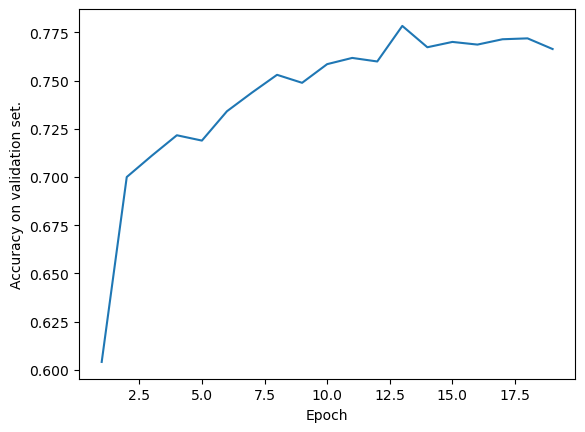

In [25]:
# (g) Tracer l'évolution des précisions tout au long de l'entraînement.
plt.plot(range(1, len(val_acc) + 1), val_acc)

plt.xlabel("Epoch")
plt.ylabel("Accuracy on validation set.")

Prédictions sur l'ensemble test.

In [26]:
# (i)
start = time.time()
test_pred = model.predict(X_test)
done = time.time()

elapsed = done - start
print(f'Prediction : {elapsed:.2f} sec \n\n')
# 0.2 sec

print(type(test_pred))  # ndarray
print(test_pred.shape)  # (2170, 1)

print(test_pred[:3, :])  # The first predictions: 1, 1, 1. 
# They are correct, although the model is only certain about the second one.

68/68 [==============================] - 0s 787us/step
Prediction : 0.18 sec 


<class 'numpy.ndarray'>
(2170, 1)
[[0.6963256 ]
 [0.92206055]
 [0.5400177 ]]


In [27]:
test_pred_class = (test_pred > 0.5).astype(int).ravel()

print(test_pred_class.shape)  # (2170, 1)

print(test_pred_class[:3])  # The first predictions: 1, 1, 1. 

(2170,)
[1 1 1]


In [28]:
print(Y_test[:3])  # [1, 1, 1]

[1 1 1]


In [29]:
# score
print("Accuracy on test set:", metrics.accuracy_score(Y_test, test_pred_class))

Accuracy on test set: 0.7663594470046083


In [30]:
print(metrics.classification_report(Y_test, test_pred_class))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1085
           1       0.76      0.77      0.77      1085

    accuracy                           0.77      2170
   macro avg       0.77      0.77      0.77      2170
weighted avg       0.77      0.77      0.77      2170



In [31]:
# confusion matrix
cm = metrics.confusion_matrix(Y_test, test_pred_class)
print(cm)

[[824 261]
 [246 839]]
